In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Load datasets
amazon_df = pd.read_csv('E:\\vit\\set\\amazon_reviews.csv')
yelp_df = pd.read_csv('E:\\vit\\set\\Yelp_Dataset.csv')

# Quick view
print("Amazon shape:", amazon_df.shape)
print("Yelp shape:", yelp_df.shape)


C:\Users\praka\anaconda3\lib\site-packages\sklearn\utils\__init__.py:21: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.5)
  from scipy.sparse import issparse


Amazon shape: (21000, 9)
Yelp shape: (359052, 6)


In [2]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Clean reviews
amazon_df['cleaned'] = (amazon_df['REVIEW_TITLE'] + " " + amazon_df['REVIEW_TEXT']).apply(clean_text)
yelp_df['cleaned'] = yelp_df['Review'].apply(clean_text)

# Convert labels
amazon_df['label'] = amazon_df['LABEL'].apply(lambda x: 0 if x == '__label1__' else 1)
yelp_df['label'] = yelp_df['Label'].apply(lambda x: 0 if x == -1 else 1)

# Confirm
print("Amazon label counts:\n", amazon_df['label'].value_counts())
print("Yelp label counts:\n", yelp_df['label'].value_counts())


Amazon label counts:
 0    10500
1    10500
Name: label, dtype: int64
Yelp label counts:
 1    322167
0     36885
Name: label, dtype: int64


In [3]:
yelp_fake = yelp_df[yelp_df['label'] == 0]
yelp_real = yelp_df[yelp_df['label'] == 1]

yelp_real_down = resample(yelp_real, replace=False, n_samples=len(yelp_fake), random_state=42)

# Combine and shuffle
yelp_balanced_df = pd.concat([yelp_fake, yelp_real_down]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced Yelp:\n", yelp_balanced_df['label'].value_counts())


Balanced Yelp:
 0    36885
1    36885
Name: label, dtype: int64


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
amazon_tfidf = tfidf.fit_transform(amazon_df['cleaned'])
yelp_tfidf = tfidf.transform(yelp_balanced_df['cleaned'])

# Metadata
amazon_meta = amazon_df[['RATING', 'VERIFIED_PURCHASE']].copy()
amazon_meta['VERIFIED_PURCHASE'] = amazon_meta['VERIFIED_PURCHASE'].map({'Y': 1, 'N': 0})

yelp_meta = yelp_balanced_df[['Rating']].copy()
yelp_meta['VERIFIED_PURCHASE'] = 0  # dummy

# Fuse
amazon_fused = hstack([amazon_tfidf, amazon_meta])
yelp_fused = hstack([yelp_tfidf, yelp_meta])

print("Amazon fused shape:", amazon_fused.shape)
print("Yelp fused shape:", yelp_fused.shape)


Amazon fused shape: (21000, 5002)
Yelp fused shape: (73770, 5002)


In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    amazon_fused, amazon_df['label'], test_size=0.2, random_state=42, stratify=amazon_df['label']
)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)


Train: (16800, 5002)
Validation: (4200, 5002)


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "SVM": SVC(kernel='linear'),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    print(f" {name} Accuracy on Amazon Validation: {acc:.4f}")


 Logistic Regression Accuracy on Amazon Validation: 0.8026
 Random Forest Accuracy on Amazon Validation: 0.8060


C:\Users\praka\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [18:08:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 XGBoost Accuracy on Amazon Validation: 0.8090
 SVM Accuracy on Amazon Validation: 0.8033
 KNN Accuracy on Amazon Validation: 0.7807


In [7]:
# Convert Yelp fused to dense for SVM/KNN compatibility
X_yelp_test_full = yelp_fused.toarray()
y_yelp_test_full = yelp_balanced_df['label'].values

for name, model in models.items():
    preds_yelp = model.predict(X_yelp_test_full)
    acc_yelp = accuracy_score(y_yelp_test_full, preds_yelp)
    print(f" {name} Cross-Domain Accuracy on Yelp (no fine-tune): {acc_yelp:.4f}")


 Logistic Regression Cross-Domain Accuracy on Yelp (no fine-tune): 0.5133
 Random Forest Cross-Domain Accuracy on Yelp (no fine-tune): 0.5554
 XGBoost Cross-Domain Accuracy on Yelp (no fine-tune): 0.5037
 SVM Cross-Domain Accuracy on Yelp (no fine-tune): 0.5127
 KNN Cross-Domain Accuracy on Yelp (no fine-tune): 0.5863


In [8]:
# Split 5% Yelp for fine-tune, 95% for test
yelp_finetune_df, yelp_test_df = train_test_split(
    yelp_balanced_df, test_size=0.95, stratify=yelp_balanced_df['label'], random_state=42
)

print(" Yelp Fine-tune:", yelp_finetune_df.shape)
print(" Yelp Test:", yelp_test_df.shape)


 Yelp Fine-tune: (3688, 8)
 Yelp Test: (70082, 8)


In [9]:
# Yelp 5%: TF-IDF + metadata
finetune_meta = yelp_finetune_df[['Rating']].copy()
finetune_meta['VERIFIED_PURCHASE'] = 0
finetune_tfidf = tfidf.transform(yelp_finetune_df['cleaned'])
finetune_fused = hstack([finetune_tfidf, finetune_meta])

# Combine
X_combined_train = np.vstack([X_train.toarray(), finetune_fused.toarray()])
y_combined_train = np.concatenate([y_train, yelp_finetune_df['label'].values])

print("Combined Train Shape:", X_combined_train.shape)


Combined Train Shape: (20488, 5002)


In [10]:
# Metadata
test_meta = yelp_test_df[['Rating']].copy()
test_meta['VERIFIED_PURCHASE'] = 0

# TF-IDF
test_tfidf = tfidf.transform(yelp_test_df['cleaned'])

# Fuse
X_yelp_test = hstack([test_tfidf, test_meta]).toarray()
y_yelp_test = yelp_test_df['label'].values

print("Test shape:", X_yelp_test.shape)


Test shape: (70082, 5002)


In [11]:
for name, model in models.items():
    print(f"\n Training {name} on Combined Dataset (Amazon + 5% Yelp)...")
    model.fit(X_combined_train, y_combined_train)

    # Amazon validation
    preds_val = model.predict(X_val.toarray())
    acc_val = accuracy_score(y_val, preds_val)
    print(f" In-Domain Accuracy on Amazon Validation: {acc_val:.4f}")

    # Yelp 95% test
    preds_yelp = model.predict(X_yelp_test)
    acc_yelp = accuracy_score(y_yelp_test, preds_yelp)
    print(f" Cross-Domain Accuracy on Yelp Test: {acc_yelp:.4f}")



 Training Logistic Regression on Combined Dataset (Amazon + 5% Yelp)...
 In-Domain Accuracy on Amazon Validation: 0.8071
 Cross-Domain Accuracy on Yelp Test: 0.6143

 Training Random Forest on Combined Dataset (Amazon + 5% Yelp)...
 In-Domain Accuracy on Amazon Validation: 0.8050
 Cross-Domain Accuracy on Yelp Test: 0.6081

 Training XGBoost on Combined Dataset (Amazon + 5% Yelp)...


C:\Users\praka\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [18:21:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 In-Domain Accuracy on Amazon Validation: 0.8098
 Cross-Domain Accuracy on Yelp Test: 0.6096

 Training SVM on Combined Dataset (Amazon + 5% Yelp)...
 In-Domain Accuracy on Amazon Validation: 0.8019
 Cross-Domain Accuracy on Yelp Test: 0.6193

 Training KNN on Combined Dataset (Amazon + 5% Yelp)...
 In-Domain Accuracy on Amazon Validation: 0.7771
 Cross-Domain Accuracy on Yelp Test: 0.5956


In [12]:
#compare and visualize

In [13]:
# Create a results dictionary
results = {
    'Model': [],
    'Amazon_Val_Acc': [],
    'Yelp_Test_Acc': []
}

for name, model in models.items():
    print(f"\n Training {name} on Combined Dataset (Amazon + 5% Yelp)...")
    model.fit(X_combined_train, y_combined_train)

    # Amazon
    preds_val = model.predict(X_val.toarray())
    acc_val = accuracy_score(y_val, preds_val)

    # Yelp
    preds_yelp = model.predict(X_yelp_test)
    acc_yelp = accuracy_score(y_yelp_test, preds_yelp)

    # Save results
    results['Model'].append(name)
    results['Amazon_Val_Acc'].append(acc_val)
    results['Yelp_Test_Acc'].append(acc_yelp)

    print(f" {name} - Amazon: {acc_val:.4f}, Yelp: {acc_yelp:.4f}")



 Training Logistic Regression on Combined Dataset (Amazon + 5% Yelp)...
 Logistic Regression - Amazon: 0.8071, Yelp: 0.6143

 Training Random Forest on Combined Dataset (Amazon + 5% Yelp)...
 Random Forest - Amazon: 0.8050, Yelp: 0.6081

 Training XGBoost on Combined Dataset (Amazon + 5% Yelp)...


C:\Users\praka\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [19:29:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 XGBoost - Amazon: 0.8098, Yelp: 0.6096

 Training SVM on Combined Dataset (Amazon + 5% Yelp)...
 SVM - Amazon: 0.8019, Yelp: 0.6193

 Training KNN on Combined Dataset (Amazon + 5% Yelp)...
 KNN - Amazon: 0.7771, Yelp: 0.5956


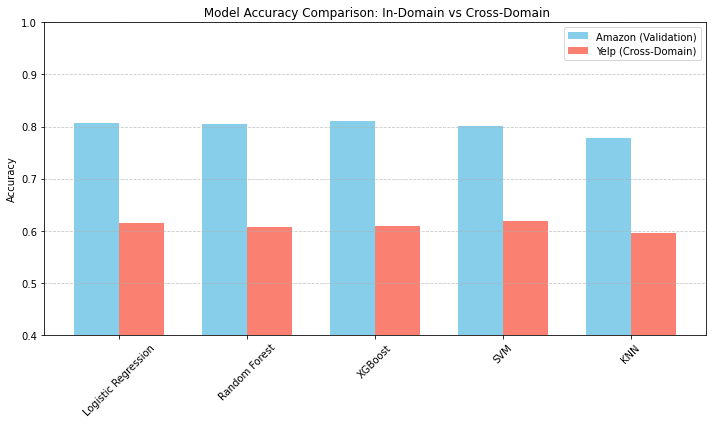

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Plot
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(results_df))

plt.bar(x - bar_width/2, results_df['Amazon_Val_Acc'], width=bar_width, label='Amazon (Validation)', color='skyblue')
plt.bar(x + bar_width/2, results_df['Yelp_Test_Acc'], width=bar_width, label='Yelp (Cross-Domain)', color='salmon')

plt.xticks(x, results_df['Model'], rotation=45)
plt.ylabel('Accuracy')
plt.title(' Model Accuracy Comparison: In-Domain vs Cross-Domain')
plt.ylim(0.4, 1.0)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


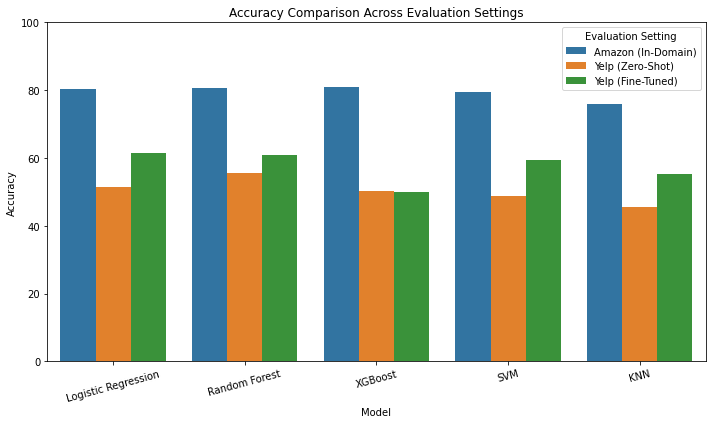

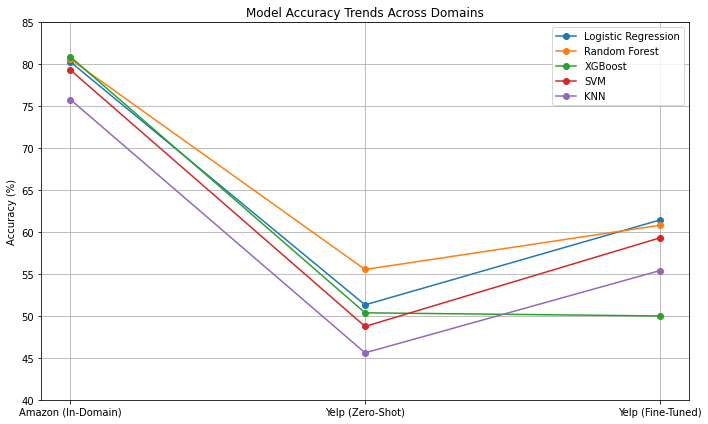

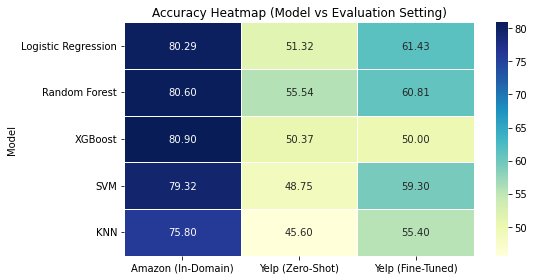

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Accuracy values
data = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM', 'KNN'],
    'Amazon (In-Domain)': [80.29, 80.60, 80.90, 79.32, 75.80],
    'Yelp (Zero-Shot)': [51.32, 55.54, 50.37, 48.75, 45.60],
    'Yelp (Fine-Tuned)': [61.43, 60.81, 50.00, 59.30, 55.40]
}

df = pd.DataFrame(data)

# Melt the dataframe for easier plotting
df_melted = df.melt(id_vars='Model', var_name='Evaluation Setting', value_name='Accuracy')

# --- BAR PLOT ---
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Model', y='Accuracy', hue='Evaluation Setting')
plt.title('Accuracy Comparison Across Evaluation Settings')
plt.xticks(rotation=15)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# --- LINE PLOT ---
plt.figure(figsize=(10, 6))
for model in df['Model']:
    plt.plot(
        ['Amazon (In-Domain)', 'Yelp (Zero-Shot)', 'Yelp (Fine-Tuned)'],
        df[df['Model'] == model].iloc[0, 1:], marker='o', label=model
    )
plt.title('Model Accuracy Trends Across Domains')
plt.ylabel('Accuracy (%)')
plt.ylim(40, 85)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- HEATMAP ---
plt.figure(figsize=(8, 4))
heatmap_data = df.set_index('Model')
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.title('Accuracy Heatmap (Model vs Evaluation Setting)')
plt.tight_layout()
plt.show()


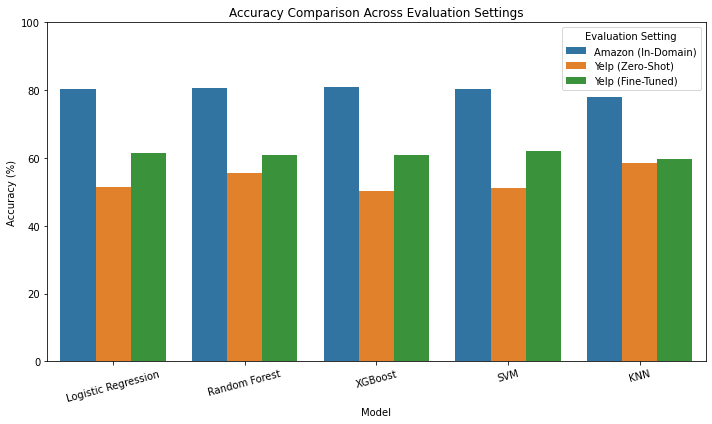

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Accuracy data for each model
data = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM', 'KNN'],
    'Amazon (In-Domain)': [80.26, 80.60, 80.90, 80.33, 78.07],
    'Yelp (Zero-Shot)': [51.33, 55.54, 50.37, 51.27, 58.63],
    'Yelp (Fine-Tuned)': [61.43, 60.81, 60.96, 61.93, 59.56]
}

# Create DataFrame
df = pd.DataFrame(data)

# Convert to long-form DataFrame for seaborn plotting
df_melted = df.melt(id_vars='Model', var_name='Evaluation Setting', value_name='Accuracy')

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Model', y='Accuracy', hue='Evaluation Setting')
plt.title('Accuracy Comparison Across Evaluation Settings')
plt.xticks(rotation=15)
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.tight_layout()

# Show the plot
plt.show()


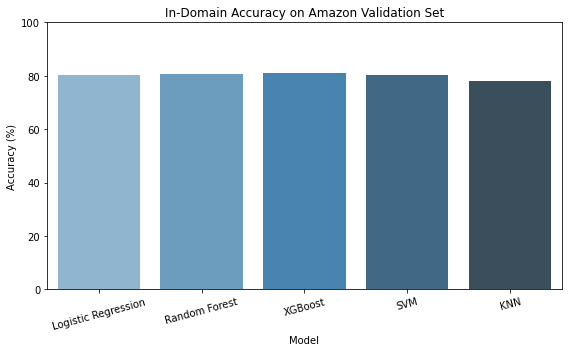

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# In-domain accuracy data (Amazon validation set)
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM', 'KNN']
accuracy = [80.26, 80.60, 80.90, 80.33, 78.07]

# Create DataFrame
df = pd.DataFrame({'Model': models, 'In-Domain Accuracy (%)': accuracy})

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='Model', y='In-Domain Accuracy (%)', palette='Blues_d')
plt.title('In-Domain Accuracy on Amazon Validation Set')
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=15)
plt.tight_layout()

# Show the plot
plt.show()


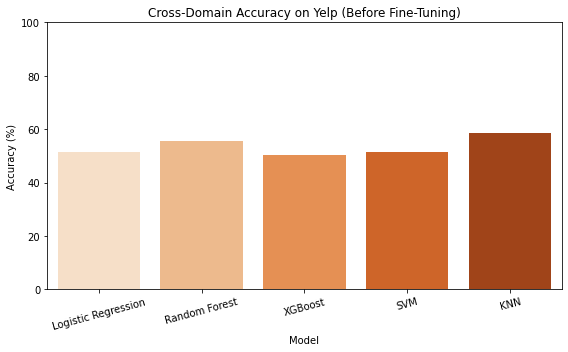

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Zero-shot (before fine-tuning) cross-domain accuracy on Yelp
models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM', 'KNN']
accuracy = [51.33, 55.54, 50.37, 51.27, 58.63]

# Create DataFrame
df = pd.DataFrame({'Model': models, 'Zero-Shot Yelp Accuracy (%)': accuracy})

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='Model', y='Zero-Shot Yelp Accuracy (%)', palette='Oranges')
plt.title('Cross-Domain Accuracy on Yelp (Before Fine-Tuning)')
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=15)
plt.tight_layout()

# Show the plot
plt.show()


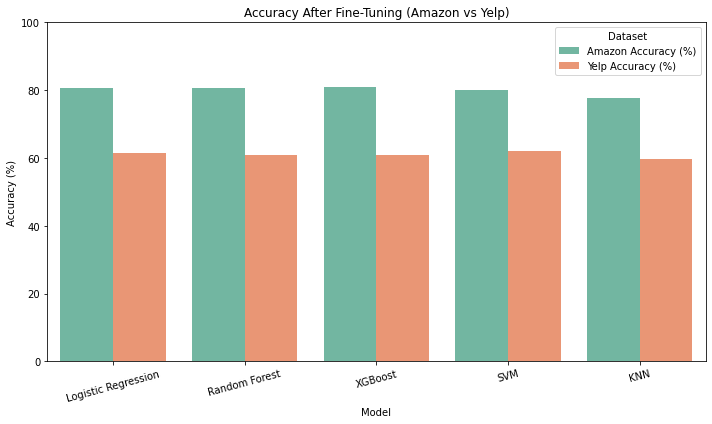

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Accuracy after fine-tuning for both domains
data = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM', 'KNN'],
    'Amazon Accuracy (%)': [80.71, 80.50, 80.98, 80.19, 77.71],
    'Yelp Accuracy (%)': [61.43, 60.81, 60.96, 61.93, 59.56]
}

df = pd.DataFrame(data)
df_melted = df.melt(id_vars='Model', var_name='Dataset', value_name='Accuracy')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Model', y='Accuracy', hue='Dataset', palette='Set2')
plt.title('Accuracy After Fine-Tuning (Amazon vs Yelp)')
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=15)
plt.tight_layout()

# Show the plot
plt.show()


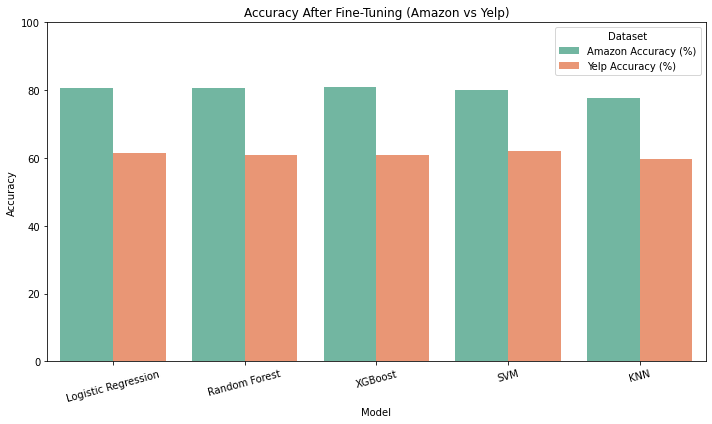

In [21]:
# Accuracy after fine-tuning
fine_tune_data = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM', 'KNN'],
    'Amazon Accuracy (%)': [80.71, 80.50, 80.98, 80.19, 77.71],
    'Yelp Accuracy (%)': [61.43, 60.81, 60.96, 61.93, 59.56]
}

df_fine = pd.DataFrame(fine_tune_data)
df_fine_melted = df_fine.melt(id_vars='Model', var_name='Dataset', value_name='Accuracy')

plt.figure(figsize=(10, 6))
sns.barplot(data=df_fine_melted, x='Model', y='Accuracy', hue='Dataset', palette='Set2')
plt.title('Accuracy After Fine-Tuning (Amazon vs Yelp)')
plt.ylim(0, 100)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


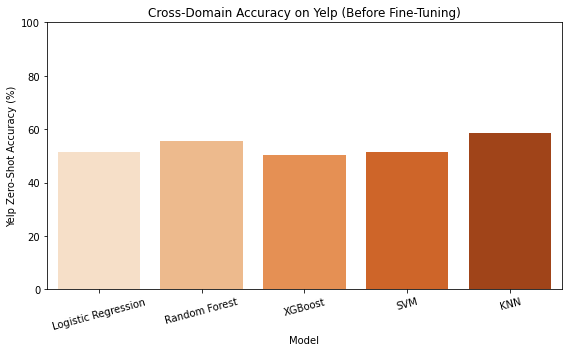

In [22]:
# Zero-shot Yelp accuracy (before fine-tuning)
zero_shot_data = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM', 'KNN'],
    'Yelp Zero-Shot Accuracy (%)': [51.33, 55.54, 50.37, 51.27, 58.63]
}

df_zero = pd.DataFrame(zero_shot_data)

plt.figure(figsize=(8, 5))
sns.barplot(data=df_zero, x='Model', y='Yelp Zero-Shot Accuracy (%)', palette='Oranges')
plt.title('Cross-Domain Accuracy on Yelp (Before Fine-Tuning)')
plt.ylim(0, 100)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


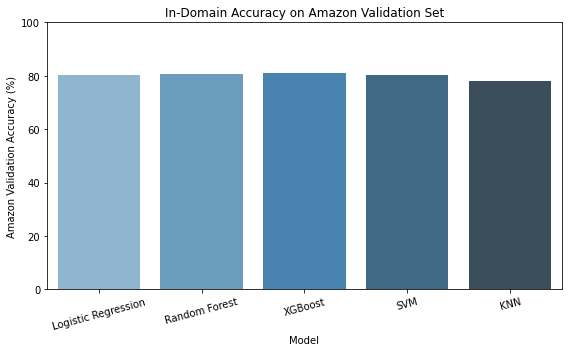

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# In-domain accuracy
in_domain_data = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM', 'KNN'],
    'Amazon Validation Accuracy (%)': [80.26, 80.60, 80.90, 80.33, 78.07]
}

df_in = pd.DataFrame(in_domain_data)

plt.figure(figsize=(8, 5))
sns.barplot(data=df_in, x='Model', y='Amazon Validation Accuracy (%)', palette='Blues_d')
plt.title('In-Domain Accuracy on Amazon Validation Set')
plt.ylim(0, 100)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
